In [2]:
# importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import cv2
import glob
import warnings
warnings.filterwarnings('ignore')
# for reading and displaying images
from skimage.io import imread
import matplotlib.pyplot as plt

# for creating validation set
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
# for evaluating the model
from sklearn.metrics import accuracy_score

# PyTorch libraries and modules
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import *
import torch.optim as optim
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.nn import Module, Conv3d, Linear, MaxPool3d, AvgPool3d, Flatten, Softmax, ReLU
from torchvision import transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
class YogaDataset(Dataset):
    def __init__(self, video_dir, label_map, transform1 = None, transform2 = None, transform3 = None):
        self.video_dir = video_dir
        self.label_map = label_map
        self.transform1 = transform1
        self.transform2 = transform2
        self.transform3 = transform3
        
        # get list of video files
        self.video_files = os.listdir(video_dir)
        
    def __len__(self):
        return len(self.video_files)
    
    def __getitem__(self, index):
        # load the video file
        filename = os.path.join(self.video_dir, self.video_files[index])
        cap = cv2.VideoCapture(filename)
        total_frames = 16
        width = 112 
        height = 112
        frames = []
        labels = []
        rand_num = np.random.rand()
        for i in range(0, total_frames):
            ret, frame = cap.read()
            if ret:
                frame = frame.astype(np.float32)
                frame = cv2.resize(frame, (width, height))
                
                if self.transform1 is not None:
                    frame = self.transform1(frame)
                if rand_num > 0.7:
                    if rand_num > 0.75:
                        frame = self.transform2(frame)
                    frame = self.transform3(frame)
                
                frames.append(frame)
                
        cap.release()
        
        # Extract label from filename
        label_value = int(self.video_files[index].split(" ")[0].replace('_', ' '))-1
        
        # Convert the frames and labels to tensors   
        frames = torch.stack(frames)
        labels = torch.tensor(label_value)
    
        return frames, labels


In [5]:
# Define the video directory and label mapping
video_dir = '/kaggle/input/yoga-classification-3dcnn/Data/'

label_map = {
    'Garland_Pose' : 0,
    'Happy_Baby_Pose' : 1,
    'Head_To_Knee_Pose' : 2,
    'Lunge_Pose' : 3,
    'Mountain_Pose' : 4,
    'Plank_Pose' : 5,
    'Raised_Arm_Pose' : 6,
    'Seated_Forward_Pose' : 7,
    'Staff_Pose' : 8,
    'Standing_Forward_Pose' : 9 
}

In [6]:
# Define the transform
transform1 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

transform2 = transforms.Compose([
    transforms.RandomHorizontalFlip(p = 0.5)
])

transform3 = transforms.Compose([
    transforms.RandomAffine(degrees = (-11, 11),
                            shear = 11,
                            translate = (0.098, 0.098),
                            scale = (0.9, 1.1))
])

In [7]:
yoga_dataset = YogaDataset(video_dir, label_map, transform1, transform2, transform3)

batch_size = 16

# Define the sizes of the training, validation, and test sets
train_size = int(0.8 * len(yoga_dataset))
val_size = int(0.1 * len(yoga_dataset))
test_size = len(yoga_dataset) - train_size - val_size

# Split the dataset into training, validation, and test sets
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(yoga_dataset, [train_size, val_size, test_size])

# Define the data loaders for the training, validation, and test sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [8]:
def load_checkpoint(checkpoint, model):
    print("Loading checkpoint...")
    model.load_state_dict(checkpoint['state_dict'])

    
def save_checkpoint(state, filename="my_checkpoint.pt"):
    print("Saving checkpoint...")
    torch.save(state, filename)

In [9]:
def get_data_loaders():
    return train_loader, test_loader

def get_test_loaders():
    return test_loader

In [10]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        self.model = nn.Sequential(
        nn.Conv3d(in_channels = 3, out_channels = 64, kernel_size = (3, 3, 3), padding = 'same'),           # Conv3d-1
        nn.ReLU(),
        nn.BatchNorm3d(64),
        nn.MaxPool3d((1, 2, 2), stride = (1, 2, 2)),                                                        # MaxPool3d-1
        nn.Conv3d(in_channels = 64, out_channels = 128, kernel_size = (3, 3, 3), padding = 'same'),         # Conv3d-2
        nn.ReLU(),
        nn.BatchNorm3d(128),
        nn.MaxPool3d((2, 2, 2), stride = (2, 2, 2)),                                                        # MaxPool3d-2
        nn.Conv3d(in_channels = 128, out_channels = 256, kernel_size = (3, 3, 3), padding = 'same'),        # Conv3d-3
        nn.ReLU(),
        nn.Conv3d(in_channels = 256, out_channels = 256, kernel_size = (3, 3, 3), padding = 'same'),        # Conv3d-4
        nn.ReLU(),
        nn.BatchNorm3d(256),
        nn.MaxPool3d((2, 2, 2), stride = (2, 2, 2)),                                                        # MaxPool3d-3
        nn.Conv3d(in_channels = 256, out_channels = 512, kernel_size = (3, 3, 3), padding = 'same'),        # Conv3d-5
        nn.ReLU(),
        nn.Conv3d(in_channels = 512, out_channels = 512, kernel_size = (3, 3, 3), padding = 'same'),        # Conv3d-6
        nn.ReLU(),
        nn.BatchNorm3d(512),
        nn.MaxPool3d((2, 2, 2), stride = (2, 2, 2)),                                                        # MaxPool3d-4
        nn.Conv3d(in_channels = 512, out_channels = 512, kernel_size = (3, 3, 3), padding = 'same'),        # Conv3d-7
        nn.ReLU(),
        nn.Conv3d(in_channels = 512, out_channels = 512, kernel_size = (3, 3, 3), padding = 'same'),        # Conv3d-8
        nn.ReLU(),
        nn.BatchNorm3d(512),
        nn.MaxPool3d((2, 2, 2), stride = (2, 2, 2)),                                                        # MaxPool3d-5
        nn.AvgPool3d((1, 3, 3), stride = (1, 1, 1)),                                                        # AvgPool3d
        nn.Dropout(p = 0.5),                                                                                # DropOut Layer
        nn.Flatten(),
        nn.Linear(512, 256),
        nn.Linear(256, 128),
        nn.Linear(128, 10),
        nn.Softmax(-1)
    )
    
    def forward(self, x):
        out = self.model(x)
        return (out)

In [11]:
model = CNNModel().to(device)
#print(model)

In [12]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), nesterov=True, lr=0.001, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=2)
# Define the number of epochs
num_epochs = 50

# Define the train and val dataloaders
train_loader, val_loader = get_data_loaders()

# Define the training and validation loops
train_losses = []
val_losses = []
train_f1_scores = []
val_f1_scores = []

In [14]:
# Training + Validation Code

for epoch in range(num_epochs):
    # Set the model to train mode
    model.train()

    # Loop over the train loader
    train_loss = 0
    train_f1 = 0
    for inputs, labels in tqdm(train_loader):
        # Transfer the inputs and labels to the device
        inputs = inputs.to(device)
        labels = labels.to(device)
        inputs = inputs.permute(0, 2, 1, 3, 4)
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels.long())

        # Backward pass
        loss.backward()
        optimizer.step()
        

        # Print statistics
        train_loss += loss.item() * inputs.size(0)
        predicted = torch.argmax(outputs, dim=1)
        train_f1 += f1_score(labels.cpu(), predicted.cpu(), average='macro') * inputs.size(0)
    
    scheduler.step(loss)
    
    train_loss /= len(train_loader.dataset)
    train_f1 /= len(train_loader.dataset)

    train_losses.append(train_loss)
    train_f1_scores.append(train_f1)

    if epoch % 5 == 0:
        checkpoint = {
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict()
        }
        torch.save(checkpoint, f"checkpoint_{epoch}.pt")

    # Set the model to evaluation mode
    model.eval()

    # Turn off gradients
    with torch.no_grad():
        val_loss = 0
        val_f1 = 0
        total_correct = 0
        total_samples = 0

        # Loop over the val loader
        for inputs, labels in tqdm(val_loader):
            # Transfer the inputs and labels to the device
            inputs = inputs.to(device)
            labels = labels.to(device)
            inputs = inputs.permute(0, 2, 1, 3, 4)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels.long())

            # Update statistics
            val_loss += loss.item() * inputs.size(0)
            predicted = torch.argmax(outputs, dim=1)
            val_f1 += f1_score(labels.cpu(), predicted.cpu(), average='macro') * inputs.size(0)
            #print(f'predicted: {predicted}')
            #print(f'ground truth: {labels}')
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

        val_loss /= len(val_loader.dataset)
        val_f1 /= len(val_loader.dataset)

        val_losses.append(val_loss)
        val_f1_scores.append(val_f1)

        # Print statistics
        accuracy = 100 * total_correct / total_samples
        print(f'Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')
        print(f'Epoch {epoch + 1}/{num_epochs}, Test Accuracy: {accuracy:.2f}%, Test F1 Score: {val_f1:.4f}')

100%|██████████| 26/26 [00:14<00:00,  1.81it/s]


Training Loss: 2.2670, Validation Loss: 2.2261
Epoch 1/50, Test Accuracy: 23.28%, Test F1 Score: 0.1182


100%|██████████| 26/26 [00:13<00:00,  1.93it/s]


Training Loss: 2.1823, Validation Loss: 2.1390
Epoch 2/50, Test Accuracy: 31.37%, Test F1 Score: 0.1631


100%|██████████| 26/26 [00:13<00:00,  1.94it/s]


Training Loss: 2.1133, Validation Loss: 2.1174
Epoch 3/50, Test Accuracy: 33.33%, Test F1 Score: 0.1923


100%|██████████| 26/26 [00:13<00:00,  1.94it/s]


Training Loss: 2.0743, Validation Loss: 2.1257
Epoch 4/50, Test Accuracy: 32.60%, Test F1 Score: 0.1878


100%|██████████| 26/26 [00:13<00:00,  1.92it/s]


Training Loss: 2.0501, Validation Loss: 2.1302
Epoch 5/50, Test Accuracy: 31.62%, Test F1 Score: 0.2055


100%|██████████| 26/26 [00:13<00:00,  1.95it/s]


Training Loss: 2.0006, Validation Loss: 2.0422
Epoch 6/50, Test Accuracy: 41.42%, Test F1 Score: 0.2542


100%|██████████| 26/26 [00:13<00:00,  1.96it/s]


Training Loss: 1.9808, Validation Loss: 2.0201
Epoch 7/50, Test Accuracy: 44.85%, Test F1 Score: 0.2777


100%|██████████| 26/26 [00:13<00:00,  1.97it/s]


Training Loss: 1.9638, Validation Loss: 2.0053
Epoch 8/50, Test Accuracy: 45.34%, Test F1 Score: 0.2895


100%|██████████| 26/26 [00:13<00:00,  1.93it/s]


Training Loss: 1.9566, Validation Loss: 1.9960
Epoch 9/50, Test Accuracy: 46.32%, Test F1 Score: 0.2860


100%|██████████| 26/26 [00:13<00:00,  1.97it/s]


Training Loss: 1.9425, Validation Loss: 1.9860
Epoch 10/50, Test Accuracy: 47.55%, Test F1 Score: 0.2985


100%|██████████| 26/26 [00:13<00:00,  1.91it/s]


Training Loss: 1.9338, Validation Loss: 1.9801
Epoch 11/50, Test Accuracy: 48.77%, Test F1 Score: 0.3200


100%|██████████| 26/26 [00:13<00:00,  1.97it/s]


Training Loss: 1.9257, Validation Loss: 1.9734
Epoch 12/50, Test Accuracy: 49.02%, Test F1 Score: 0.3140


100%|██████████| 26/26 [00:13<00:00,  1.95it/s]


Training Loss: 1.9237, Validation Loss: 1.9693
Epoch 13/50, Test Accuracy: 49.51%, Test F1 Score: 0.3206


100%|██████████| 26/26 [00:13<00:00,  1.92it/s]


Training Loss: 1.9185, Validation Loss: 1.9713
Epoch 14/50, Test Accuracy: 50.00%, Test F1 Score: 0.3255


100%|██████████| 26/26 [00:13<00:00,  1.95it/s]


Training Loss: 1.9136, Validation Loss: 1.9673
Epoch 15/50, Test Accuracy: 50.00%, Test F1 Score: 0.3288


100%|██████████| 26/26 [00:13<00:00,  1.90it/s]


Training Loss: 1.9183, Validation Loss: 1.9806
Epoch 16/50, Test Accuracy: 49.02%, Test F1 Score: 0.3221


100%|██████████| 26/26 [00:13<00:00,  1.98it/s]


Training Loss: 1.9188, Validation Loss: 1.9692
Epoch 17/50, Test Accuracy: 50.25%, Test F1 Score: 0.3262


100%|██████████| 26/26 [00:13<00:00,  1.90it/s]


Training Loss: 1.9229, Validation Loss: 1.9732
Epoch 18/50, Test Accuracy: 49.26%, Test F1 Score: 0.3188


100%|██████████| 26/26 [00:13<00:00,  1.94it/s]


Training Loss: 1.9172, Validation Loss: 1.9752
Epoch 19/50, Test Accuracy: 49.26%, Test F1 Score: 0.3178


100%|██████████| 26/26 [00:13<00:00,  1.89it/s]


Training Loss: 1.9172, Validation Loss: 1.9716
Epoch 20/50, Test Accuracy: 50.25%, Test F1 Score: 0.3307


100%|██████████| 26/26 [00:13<00:00,  1.96it/s]


Training Loss: 1.9262, Validation Loss: 1.9695
Epoch 21/50, Test Accuracy: 49.75%, Test F1 Score: 0.3187


100%|██████████| 26/26 [00:13<00:00,  1.91it/s]


Training Loss: 1.9125, Validation Loss: 1.9795
Epoch 22/50, Test Accuracy: 48.77%, Test F1 Score: 0.3169


100%|██████████| 26/26 [00:13<00:00,  1.94it/s]


Training Loss: 1.9125, Validation Loss: 1.9724
Epoch 23/50, Test Accuracy: 49.51%, Test F1 Score: 0.3164


100%|██████████| 26/26 [00:13<00:00,  1.97it/s]


Training Loss: 1.9180, Validation Loss: 1.9761
Epoch 24/50, Test Accuracy: 48.77%, Test F1 Score: 0.3244


100%|██████████| 26/26 [00:13<00:00,  1.88it/s]


Training Loss: 1.9165, Validation Loss: 1.9765
Epoch 25/50, Test Accuracy: 49.02%, Test F1 Score: 0.3188


100%|██████████| 26/26 [00:13<00:00,  1.97it/s]


Training Loss: 1.9194, Validation Loss: 1.9682
Epoch 26/50, Test Accuracy: 50.00%, Test F1 Score: 0.3250


100%|██████████| 26/26 [00:13<00:00,  1.88it/s]


Training Loss: 1.9184, Validation Loss: 1.9748
Epoch 27/50, Test Accuracy: 48.53%, Test F1 Score: 0.3101


100%|██████████| 26/26 [00:13<00:00,  1.93it/s]


Training Loss: 1.9211, Validation Loss: 1.9834
Epoch 28/50, Test Accuracy: 48.28%, Test F1 Score: 0.3129


100%|██████████| 26/26 [00:13<00:00,  1.90it/s]


Training Loss: 1.9192, Validation Loss: 1.9738
Epoch 29/50, Test Accuracy: 49.51%, Test F1 Score: 0.3230


100%|██████████| 26/26 [00:13<00:00,  1.90it/s]


Training Loss: 1.9182, Validation Loss: 1.9760
Epoch 30/50, Test Accuracy: 48.77%, Test F1 Score: 0.3134


100%|██████████| 26/26 [00:13<00:00,  1.93it/s]


Training Loss: 1.9168, Validation Loss: 1.9659
Epoch 31/50, Test Accuracy: 50.25%, Test F1 Score: 0.3276


100%|██████████| 26/26 [00:14<00:00,  1.83it/s]


Training Loss: 1.9185, Validation Loss: 1.9826
Epoch 32/50, Test Accuracy: 47.79%, Test F1 Score: 0.3074


100%|██████████| 26/26 [00:13<00:00,  1.91it/s]


Training Loss: 1.9180, Validation Loss: 1.9731
Epoch 33/50, Test Accuracy: 48.77%, Test F1 Score: 0.3136


100%|██████████| 26/26 [00:14<00:00,  1.81it/s]


Training Loss: 1.9174, Validation Loss: 1.9741
Epoch 34/50, Test Accuracy: 49.02%, Test F1 Score: 0.3136


100%|██████████| 26/26 [00:14<00:00,  1.84it/s]


Training Loss: 1.9132, Validation Loss: 1.9737
Epoch 35/50, Test Accuracy: 49.02%, Test F1 Score: 0.3094


100%|██████████| 26/26 [00:13<00:00,  1.88it/s]


Training Loss: 1.9182, Validation Loss: 1.9811
Epoch 36/50, Test Accuracy: 48.04%, Test F1 Score: 0.3073


100%|██████████| 26/26 [00:13<00:00,  1.90it/s]


Training Loss: 1.9160, Validation Loss: 1.9714
Epoch 37/50, Test Accuracy: 49.51%, Test F1 Score: 0.3208


100%|██████████| 26/26 [00:13<00:00,  1.89it/s]


Training Loss: 1.9201, Validation Loss: 1.9725
Epoch 38/50, Test Accuracy: 49.26%, Test F1 Score: 0.3187


100%|██████████| 26/26 [00:13<00:00,  1.89it/s]


Training Loss: 1.9187, Validation Loss: 1.9781
Epoch 39/50, Test Accuracy: 48.28%, Test F1 Score: 0.3125


100%|██████████| 26/26 [00:13<00:00,  1.92it/s]


Training Loss: 1.9173, Validation Loss: 1.9752
Epoch 40/50, Test Accuracy: 49.02%, Test F1 Score: 0.3132


100%|██████████| 26/26 [00:13<00:00,  1.92it/s]


Training Loss: 1.9144, Validation Loss: 1.9767
Epoch 41/50, Test Accuracy: 48.53%, Test F1 Score: 0.3151


100%|██████████| 26/26 [00:14<00:00,  1.84it/s]


Training Loss: 1.9164, Validation Loss: 1.9746
Epoch 42/50, Test Accuracy: 49.02%, Test F1 Score: 0.3138


100%|██████████| 26/26 [00:13<00:00,  1.92it/s]


Training Loss: 1.9134, Validation Loss: 1.9666
Epoch 43/50, Test Accuracy: 49.51%, Test F1 Score: 0.3289


100%|██████████| 26/26 [00:13<00:00,  1.90it/s]


Training Loss: 1.9168, Validation Loss: 1.9833
Epoch 44/50, Test Accuracy: 49.02%, Test F1 Score: 0.3187


100%|██████████| 26/26 [00:13<00:00,  1.93it/s]


Training Loss: 1.9176, Validation Loss: 1.9762
Epoch 45/50, Test Accuracy: 49.51%, Test F1 Score: 0.3240


100%|██████████| 26/26 [00:13<00:00,  1.92it/s]


Training Loss: 1.9184, Validation Loss: 1.9763
Epoch 46/50, Test Accuracy: 48.77%, Test F1 Score: 0.3125


100%|██████████| 26/26 [00:13<00:00,  1.91it/s]


Training Loss: 1.9183, Validation Loss: 1.9710
Epoch 47/50, Test Accuracy: 50.00%, Test F1 Score: 0.3270


100%|██████████| 26/26 [00:13<00:00,  1.90it/s]


Training Loss: 1.9124, Validation Loss: 1.9765
Epoch 48/50, Test Accuracy: 49.02%, Test F1 Score: 0.3143


100%|██████████| 26/26 [00:13<00:00,  1.87it/s]


Training Loss: 1.9225, Validation Loss: 1.9813
Epoch 49/50, Test Accuracy: 48.04%, Test F1 Score: 0.3196


100%|██████████| 26/26 [00:13<00:00,  1.88it/s]

Training Loss: 1.9189, Validation Loss: 1.9778
Epoch 50/50, Test Accuracy: 49.75%, Test F1 Score: 0.3253


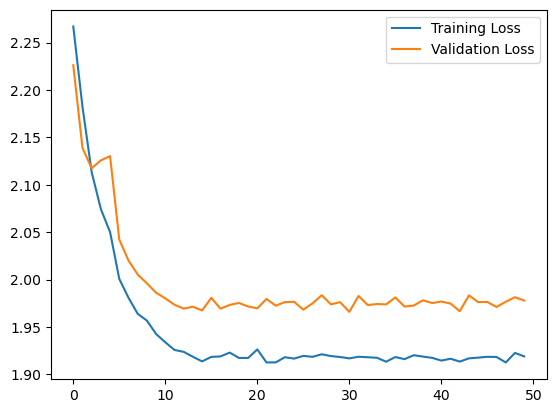

In [15]:
# Plot the training and validation losses

plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')

plt.legend()

In [16]:
# Define the test data loader
test_loader = get_test_loaders()

# Set the model to evaluation mode
model.eval()

# Turn off gradients
with torch.no_grad():
    total_correct = 0
    total_samples = 0
    all_predicted = []
    all_labels = []

    # Loop over the test loader
    for inputs, labels in tqdm(test_loader):
        # Transfer the inputs and labels to the device
        inputs = inputs.to(device)
        labels = labels.to(device)
        inputs = inputs.permute(0, 2, 1, 3, 4)

        # Forward pass
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        # Update statistics
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)
        all_predicted.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    # Print statistics
    accuracy = 100 * total_correct / total_samples
    f1 = f1_score(all_labels, all_predicted, average='macro')
    print(f'Test Accuracy: {accuracy:.2f}%')
    print(f'F1 Score: {f1:.4f}')


100%|██████████| 26/26 [00:13<00:00,  1.93it/s]

Test Accuracy: 50.25%
F1 Score: 0.3611
